# MVP

Minimum Viable Project

In [3]:
import pandas as pd
import numpy as np
import datetime
from itertools import combinations

from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [46]:
%load_ext watermark
%watermark -iv -psklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      1.15.4
pandas     0.24.2
matplotlib 3.0.3
sklearn 0.20.1


## Data load and clean

In [5]:
train = pd.read_csv('../data/train_sample.csv', parse_dates=['click_time', 'attributed_time'])
train.shape

(100000, 8)

In [6]:
train.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaT,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaT,0
7,121505,9,1,25,442,2017-11-07 10:01:53,NaT,0
8,192967,2,2,22,364,2017-11-08 09:35:17,NaT,0
9,143636,3,1,19,135,2017-11-08 12:35:26,NaT,0


The only column that's not basically just an "id" is the click_time, so I decided to
just bin it. It's a little hacky but: 1) picked bin strategy and number of bins so that
plot looked semi-decent. Then I recentered the data so that it looked more like a normal
curve. (In the oringal plot, the first bin is large and the last bin is small
because the algorithm doesn't know these times are essentially
consecutive, just the next day. I decided to move that confused area to the low spot
of the graph.)

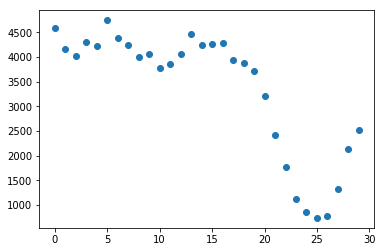

In [27]:
# I just played with the number of bins until it looked sort of smooth-ish
# then moved the center until it looked kinda normal-ish

train['click_minute'] = train.click_time.map(lambda x : x.hour * 60 + x.minute)

hour_bins = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='kmeans')
train['time_bin'] = hour_bins.fit_transform(train.click_minute.values.reshape(-1,1))

bin_check = train.time_bin.value_counts()
plt.scatter(bin_check.index, bin_check.values)


In [28]:
hour_bins.inverse_transform(np.array([25]).reshape(1,-1))

array([[1225.68204536]])

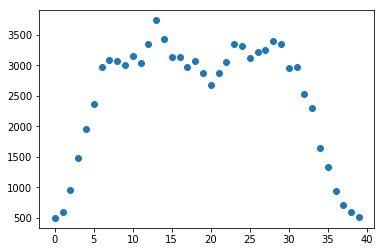

In [29]:
temp = train.click_minute -  1225
one_day = 24*60
new = temp.copy()
new[temp < 0] += one_day

train.click_minute = new
hour_bins = KBinsDiscretizer(n_bins=40, encode='ordinal', strategy='kmeans')
train['time_bin'] = hour_bins.fit_transform(train.click_minute.values.reshape(-1,1))

bin_check = train.time_bin.value_counts()
plt.scatter(bin_check.index, bin_check.values)

In [30]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_minute,time_bin
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,785,21.0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,1035,28.0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,1300,36.0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,513,14.0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,755,20.0


## Feature engineering

Following Sonia's observation that the terms interact, but going brute force and trying 
every possible pair of features.

In [31]:
unigrams = ['ip', 'app', 'device', 'os', 'channel', 'time_bin']
bigrams = combinations(unigrams, 2)

cols = []

df_big = pd.DataFrame()
for c1,c2 in bigrams:
    col = '_'.join([c1,c2])
    cols += [col]
    df_big[col] = train[c1].combine(train[c2], lambda x,y:(x,y))
    

In [32]:
df_big.head()

,ip_app,ip_device,ip_os,ip_channel,ip_time_bin,app_device,app_os,app_channel,app_time_bin,device_os,device_channel,device_time_bin,os_channel,os_time_bin,channel_time_bin
0,"(87540, 12)","(87540, 1)","(87540, 13)","(87540, 497)","(87540, 21.0)","(12, 1)","(12, 13)","(12, 497)","(12, 21.0)","(1, 13)","(1, 497)","(1, 21.0)","(13, 497)","(13, 21.0)","(497, 21.0)"
1,"(105560, 25)","(105560, 1)","(105560, 17)","(105560, 259)","(105560, 28.0)","(25, 1)","(25, 17)","(25, 259)","(25, 28.0)","(1, 17)","(1, 259)","(1, 28.0)","(17, 259)","(17, 28.0)","(259, 28.0)"
2,"(101424, 12)","(101424, 1)","(101424, 19)","(101424, 212)","(101424, 36.0)","(12, 1)","(12, 19)","(12, 212)","(12, 36.0)","(1, 19)","(1, 212)","(1, 36.0)","(19, 212)","(19, 36.0)","(212, 36.0)"
3,"(94584, 13)","(94584, 1)","(94584, 13)","(94584, 477)","(94584, 14.0)","(13, 1)","(13, 13)","(13, 477)","(13, 14.0)","(1, 13)","(1, 477)","(1, 14.0)","(13, 477)","(13, 14.0)","(477, 14.0)"
4,"(68413, 12)","(68413, 1)","(68413, 1)","(68413, 178)","(68413, 20.0)","(12, 1)","(12, 1)","(12, 178)","(12, 20.0)","(1, 1)","(1, 178)","(1, 20.0)","(1, 178)","(1, 20.0)","(178, 20.0)"


## Computing TF-IDF values

Following Leila's suggestion to try Naive Bayes: I'm going to need to do some sort of way to do "word" counts
of each bigram. Using the basic formula for the IDF part of TF-IDF since each pair only arrives once per row.

In [33]:
val_counts = {}
for col in cols:
    val_counts[col] = df_big[col].value_counts()

tf_idf = pd.DataFrame(index=df_big.index, columns=cols)

N = tf_idf.shape[0]

def tfidf_mapper(val, col):
    global val_counts, N
    val_count = val_counts[col][val]
    return  np.log( np.float(N)/np.float(val_count+1))
    
for col in cols:
    tf_idf[col] = df_big[col].apply(tfidf_mapper, args=(col,))

In [34]:
tf_idf.head()

,ip_app,ip_device,ip_os,ip_channel,ip_time_bin,app_device,app_os,app_channel,app_time_bin,device_os,device_channel,device_time_bin,os_channel,os_time_bin,channel_time_bin
0,10.126631,9.315701,10.126631,10.819778,10.819778,2.083610,3.534957,6.036462,5.451469,1.589341,6.040655,3.609699,7.487574,5.119335,9.210340
1,9.903488,6.557098,9.315701,9.433484,9.567015,4.887533,7.902008,4.822083,7.875339,3.000142,3.582000,3.469583,6.400938,6.170591,6.812445
2,10.819778,10.414313,10.414313,10.819778,10.819778,2.083610,3.468299,6.600271,6.475973,1.454959,5.060877,4.714985,6.543112,6.061887,9.210340
3,10.819778,10.126631,10.819778,10.819778,10.819778,3.748205,5.288367,4.117818,6.991137,1.589341,3.247533,3.421604,4.828314,4.908982,6.388961
4,10.414313,9.903488,10.819778,10.819778,10.819778,2.083610,6.692644,3.646203,5.615772,4.453308,3.618607,3.669469,8.078938,8.111728,7.082109


## Resampling

We have massively imbalanced learning problem. To rebalance, I'm downsampling class 0 massively and
upsampling class 1.

In [35]:
y = train.is_attributed
tf_idf['y'] = y 

# downsample 0, upsample 1 - will improve later

class0 = tf_idf.loc[y == 0, :]
class1 = tf_idf.loc[y == 1, :]

class0 = class0.sample(frac=.025)
class1 = class1.sample(frac=10., replace=True)

subsample = pd.concat([class0, class1])

X = subsample.drop(columns='y')
y = subsample.y

y.value_counts()

0    2494
1    2270
Name: y, dtype: int64

## Naive Bayes

Now ready to do NaiveBayes:

In [36]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X,y)
yhat = clf.predict(X)
roc_auc_score(y, yhat)

0.894271538034896

In [37]:
# Try the 97 % of class 0 that we threw out above
X_train = tf_idf.drop(columns='y')
y_train = tf_idf.y
yhat = clf.predict(X_train)
roc_auc_score(y_train, yhat)

0.8926525989326166

## A bunch of other random models
(One advantage of throwing away 98% of the data is that it's really fast to train other models...)

### Logistic Regression

In [38]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(cv=4, 
                         scoring='roc_auc', 
                         verbose=1, 
                         n_jobs=-1, 
                         max_iter=300, 
                         fit_intercept=True)
)
pipe.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=300,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=1))])

In [39]:
yhat = pipe.predict(X)
roc_auc_score(y, yhat)

0.9155990235596267

In [40]:
yhat = pipe.predict(X_train)
roc_auc_score(y_train, yhat)

0.9155047596811282

### Stochastic Gradient Descent


In [41]:
pipe = make_pipeline(
    StandardScaler(),
    SGDClassifier(max_iter=1000, tol=1e-3)
)
pipe.fit(X,y)
yhat = pipe.predict(X)
print('Subset AUC', roc_auc_score(y, yhat))
yhat = pipe.predict(X_train)
roc_auc_score(y_train, yhat)
print('Full AUC', roc_auc_score(y_train, yhat))

Subset AUC 0.9203261395631454
Full AUC 0.9163543313806923


### Neural Network 

In [42]:
from sklearn.neural_network import MLPClassifier
pipe = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(20,20,20), validation_fraction=.2, max_iter=1000)
)
pipe.fit(X,y)
yhat = pipe.predict(X)
print('Subset AUC', roc_auc_score(y, yhat))
yhat = pipe.predict(X_train)
roc_auc_score(y_train, yhat)
print('Full AUC', roc_auc_score(y_train, yhat))

Subset AUC 0.9973937449879711
Full AUC 0.9873863670532108


### Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
pipe = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier()
)
pipe.fit(X,y)
yhat = pipe.predict(X)
print('Subset AUC', roc_auc_score(y, yhat))
yhat = pipe.predict(X_train)
roc_auc_score(y_train, yhat)
print('Full AUC', roc_auc_score(y_train, yhat))

Subset AUC 0.9881742613991642
Full AUC 0.982414795241586


# Possible places to go after MVP:
- Train on full (resampled) train set and upload test set to kaggle and see what that score is
- Actually look for relevant bigrams (up to n-grams?) and do feature selection to improve the inputs
- Use cross validation and grid search to tune the various models
- Use a "better" library for neural network and boosting (e.g. Tensorflow, SparkML, XGBoost, etc.)